In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory # pip install tf-nightly

In [2]:
tf.debugging.set_log_device_placement(False)  # don't show device log
print("Num GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
DATASET_DIR = "./dataset/sdd"

TRAIN_DATASET_DIR = DATASET_DIR + '/train'

TEST_DATASET_DIR = DATASET_DIR + '/test'

IMG_SIZE = (32, 32)

BATCH_SIZE = 32

In [4]:
# build train dataset
train_ds = image_dataset_from_directory(directory=TRAIN_DATASET_DIR,
                                        labels='inferred',
                                        label_mode='categorical',
                                        shuffle=True,
                                        batch_size=BATCH_SIZE,
                                        image_size=IMG_SIZE)

#build test dataset
test_ds = image_dataset_from_directory(directory=TEST_DATASET_DIR,
                                       labels='inferred',
                                       label_mode='categorical',
                                       shuffle=False,
                                       batch_size=BATCH_SIZE,
                                       image_size=IMG_SIZE)

Found 16229 files belonging to 120 classes.
Found 4111 files belonging to 120 classes.


In [5]:
# build class dict
print("\ntraing dataset size:", len(train_ds))
print("test dataset size:", len(test_ds))
print("\nclass names:\n", train_ds.class_names)


traing dataset size: 508
test dataset size: 129

class names:
 ['n02085620-Chihuahua', 'n02085782-Japanese_spaniel', 'n02085936-Maltese_dog', 'n02086079-Pekinese', 'n02086240-Shih-Tzu', 'n02086646-Blenheim_spaniel', 'n02086910-papillon', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02088094-Afghan_hound', 'n02088238-basset', 'n02088364-beagle', 'n02088466-bloodhound', 'n02088632-bluetick', 'n02089078-black-and-tan_coonhound', 'n02089867-Walker_hound', 'n02089973-English_foxhound', 'n02090379-redbone', 'n02090622-borzoi', 'n02090721-Irish_wolfhound', 'n02091032-Italian_greyhound', 'n02091134-whippet', 'n02091244-Ibizan_hound', 'n02091467-Norwegian_elkhound', 'n02091635-otterhound', 'n02091831-Saluki', 'n02092002-Scottish_deerhound', 'n02092339-Weimaraner', 'n02093256-Staffordshire_bullterrier', 'n02093428-American_Staffordshire_terrier', 'n02093647-Bedlington_terrier', 'n02093754-Border_terrier', 'n02093859-Kerry_blue_terrier', 'n02093991-Irish_terrier', 'n02094114-Norfo

train_imgs.shape:  (32, 32, 32, 3)
train_labels.shape:  (32, 120)
['n02102480-Sussex_spaniel', 'n02091134-whippet', 'n02107142-Doberman', 'n02101556-clumber', 'n02093754-Border_terrier', 'n02108000-EntleBucher', 'n02102480-Sussex_spaniel', 'n02096294-Australian_terrier', 'n02091244-Ibizan_hound', 'n02115641-dingo', 'n02115641-dingo', 'n02097047-miniature_schnauzer', 'n02098413-Lhasa', 'n02107312-miniature_pinscher', 'n02086079-Pekinese', 'n02113978-Mexican_hairless', 'n02087046-toy_terrier', 'n02087394-Rhodesian_ridgeback', 'n02110958-pug', 'n02112018-Pomeranian', 'n02091244-Ibizan_hound', 'n02098413-Lhasa', 'n02097658-silky_terrier', 'n02105056-groenendael', 'n02116738-African_hunting_dog', 'n02113799-standard_poodle', 'n02089867-Walker_hound', 'n02087046-toy_terrier', 'n02088466-bloodhound', 'n02097658-silky_terrier', 'n02107908-Appenzeller', 'n02112137-chow']


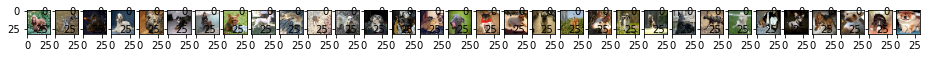

In [6]:
# show train batch
for data in train_ds:
    train_imgs, train_labels = data
    break
print("train_imgs.shape: ", train_imgs.shape)
print("train_labels.shape: ", train_labels.shape)

plt.figure(num=BATCH_SIZE, figsize=(16, 16))
for i, img in enumerate(train_imgs):
    plt.subplot(1, BATCH_SIZE, i + 1)
    plt.imshow(tf.make_ndarray(tf.make_tensor_proto(img)).astype('uint8'))

labels = [
    train_ds.class_names[np.where(label == 1)[0][0]] for label in train_labels
]
print(labels)

In [7]:
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(120, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)

        return x


model = MyModel()

In [8]:
for data in train_ds:
    imgs, labels = data
    break
model.build(imgs.shape)
print(model.summary())

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3686528   
_________________________________________________________________
dense_1 (Dense)              multiple                  15480     
Total params: 3,702,904
Trainable params: 3,702,904
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
EPOCHS = 2

loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

optimizer = tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(train_ds,
          steps_per_epoch=len(train_ds),
          validation_data=test_ds,
          validation_steps=len(test_ds),
          epochs=EPOCHS)

Epoch 1/2
508/508 [==============================] - 38s 75ms/step - loss: 11.8076 - accuracy: 0.0097 - val_loss: 4.7849 - val_accuracy: 0.0119
Epoch 2/2
508/508 [==============================] - 37s 74ms/step - loss: 4.7791 - accuracy: 0.0118 - val_loss: 4.7838 - val_accuracy: 0.0122
